

# RNN for breast cancer dataset

In [ ]:
# import necessary libraries
import os
import torch
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
data = pd.read_csv('/content/data.csv')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [ ]:
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [ ]:
# diagnosis distribution
data['diagnosis'].value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

In [ ]:
# encode categorical data
data['diagnosis'].replace({'M': 1, 'B': 0}, inplace = True)

In [ ]:
Y = data['diagnosis'].to_numpy()

In [ ]:
X = data.drop(['id', 'diagnosis', 'Unnamed: 32'], axis = 1)

In [ ]:
# split the dataset into the training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3)

In [ ]:
# feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# create the model
model = torch.nn.Linear(X_train.shape[1], 1)

In [ ]:
# load sets in format compatible with pytorch
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))

In [ ]:
y_train = torch.from_numpy(y_train).float().reshape(-1, 1)
y_test = torch.from_numpy(y_test).float().reshape(-1, 1)

specify the hyperparameters and iterate through the train data to run the model

In [ ]:
def configure_loss_function():
    return torch.nn.BCEWithLogitsLoss()

In [ ]:
# use Adam optimiser for gradient descent
def configure_optimizer(model):
    return torch.optim.Adam(model.parameters(), lr = 0.0007)

In [ ]:
# define the loss function to compare the output with the target
criterion = configure_loss_function()
optimizer = configure_optimizer(model)

In [ ]:
# run the model
epochs = 5
# initialise the train_loss & test_losses which will be updated
train_losses = np.zeros(epochs)
test_losses = np.zeros(epochs)

for epoch in range(epochs):
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    # clear old gradients from the last step
    optimizer.zero_grad()
    # compute the gradients necessary to adjust the weights
    loss.backward()
    # update the weights of the neural network
    optimizer.step()

    outputs_test = model(X_test)
    loss_test = criterion(outputs_test, y_test)

    train_losses[epoch] = loss.item()
    test_losses[epoch] = loss_test.item()

    if (epoch + 1) % 50 == 0:
      print (str('Epoch ') + str((epoch+1)) + str('/') + str(epochs) + str(',  training loss = ') + str((loss.item())) + str(', test loss = ') + str(loss_test.item()))

Text(0.5, 1.0, 'Model Loss')

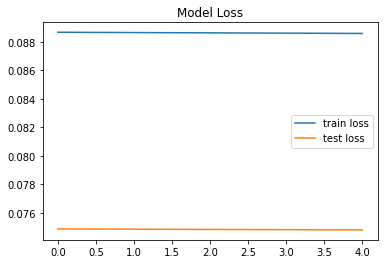

In [ ]:
# visualise the test and train loss
plt.plot(train_losses, label = 'train loss')
plt.plot(test_losses, label = 'test loss')
plt.legend()
plt.title('Model Loss')

In [ ]:
with torch.no_grad():
  output_train = model(X_train)
  output_train = (output_train.numpy() > 0)

  train_acc = np.mean(y_train.numpy() == output_train)

  output_test = model(X_test)
  output_test = (output_test.numpy() > 0)

  test_acc = np.mean(y_test.numpy() == output_test)

In [ ]:
print ('Train accuracy is: ' + str(train_acc))

Train accuracy is: 0.9748743718592965


In [ ]:
print ('Test accuracy is: ' + str(train_acc))

Test accuracy is: 0.9748743718592965


# RNN for heart failure dataset

In [ ]:
# import necessary libraries
import os
import torch
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
data = pd.read_csv('/content/heart_failure_clinical_records_dataset.csv')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [ ]:
data['anaemia'].value_counts()

0    170
1    129
Name: anaemia, dtype: int64

In [ ]:
data['anaemia'].replace({'M': 1, 'B': 0}, inplace = True)

In [ ]:
Y = data['anaemia'].to_numpy()

In [ ]:
X = data['smoking'].to_numpy()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3)

In [ ]:
# create the model
model = torch.nn.Linear(X_train.shape[1], 1)

In [ ]:
# load sets in format compatible with pytorch
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))

In [ ]:
y_train = torch.from_numpy(y_train).float().reshape(-1, 1)
y_test = torch.from_numpy(y_test).float().reshape(-1, 1)

In [ ]:
def configure_loss_function():
    return torch.nn.BCEWithLogitsLoss()

In [ ]:
# use Adam optimiser for gradient descent
def configure_optimizer(model):
    return torch.optim.Adam(model.parameters(), lr = 0.0007)

In [ ]:
# define the loss function to compare the output with the target
criterion = configure_loss_function()
optimizer = configure_optimizer(model)

In [ ]:
# run the model
epochs = 5
# initialise the train_loss & test_losses which will be updated
train_losses = np.zeros(epochs)
test_losses = np.zeros(epochs)

for epoch in range(epochs):
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    # clear old gradients from the last step
    optimizer.zero_grad()
    # compute the gradients necessary to adjust the weights
    loss.backward()
    # update the weights of the neural network
    optimizer.step()

    outputs_test = model(X_test)
    loss_test = criterion(outputs_test, y_test)

    train_losses[epoch] = loss.item()
    test_losses[epoch] = loss_test.item()

    if (epoch + 1) % 50 == 0:
      print (str('Epoch ') + str((epoch+1)) + str('/') + str(epochs) + str(',  training loss = ') + str((loss.item())) + str(', test loss = ') + str(loss_test.item()))

Text(0.5, 1.0, 'Model Loss')

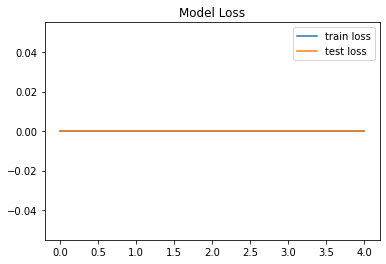

In [ ]:
# visualise the test and train loss
plt.plot(train_losses, label = 'train loss')
plt.plot(test_losses, label = 'test loss')
plt.legend()
plt.title('Model Loss')

In [ ]:
print ('Train accuracy is: ' + str(train_acc))

Train accuracy is: 0.9748743718592965


In [ ]:
print ('Test accuracy is: ' + str(train_acc))

Test accuracy is: 0.9748743718592965
